<a href="https://colab.research.google.com/github/LeoLomardo/Inteligencia-Computacional-Aplicada/blob/main/Redes%20Neurais/Trabalho%201/Trabalho1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
colab = True
if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    import os
    os.chdir('/content/PUC_Redes_Neurais/grad/lista 1')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 297 (delta 110), reused 231 (delta 44), pack-reused 0
Receiving objects: 100% (297/297), 3.98 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (110/110), done.


# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Aluno:
Leo Land Bairos Lomardo - 2020201
Base de dados: occupancy_detection
e-mail: leoland771@gmail.com

e-mail Thiago: thiago.medeiros.carvalho@gmail.com
e-mail Marley: marley@ele.puc-rio.br

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<b> Importante: </b> faça uma média dos resultados para cada item. Como o modelo é estocástico, os resultados podem variar de acordo com a inicialização dos pesos.

In [ ]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import sleep
import requests

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train


In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 2/3 camada de entrada + camada de saida 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [ ]:
dataset_name = 'occupancy_detection'
dataset_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [ ]:
resp = requests.get(info_path)
info = json.loads(resp.text)

In [ ]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [ ]:
for i in dataset.dtypes.items():
    print(i)

('date', dtype('O'))
('Temperature', dtype('float64'))
('Humidity', dtype('float64'))
('Light', dtype('float64'))
('CO2', dtype('float64'))
('HumidityRatio', dtype('float64'))
('target', dtype('int64'))


## Parte I - Compreensão do problema e análise de variáveis

Total: 1,0 pts.


### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

A data não agrega no treinamento da rede, então será removida.
Fiquei na duvida em relação a data/hora pq a temp varia de acordo com hora do dia e num de pessoas, ex meio dia-> mt quente, mas se tiver quente meia noite==mais gente. Porém tem concentração de carbono, nn sendo necessário a data.

Fiquei na dúvida em relação ao grau de correlação dos dados umidade/temp umidade relativa
https://repositorio.unesp.br/bitstream/handle/11449/193623/vilela_db_me_ilha.pdf?sequence=3&isAllowed=y





In [ ]:
dataset

date  Temperature  Humidity  Light         CO2  \
0     2015-02-04 17:51:00        23.18   27.2720  426.0  721.250000   
1     2015-02-04 17:51:59        23.15   27.2675  429.5  714.000000   
2     2015-02-04 17:53:00        23.15   27.2450  426.0  713.500000   
3     2015-02-04 17:54:00        23.15   27.2000  426.0  708.250000   
4     2015-02-04 17:55:00        23.10   27.2000  426.0  704.500000   
...                   ...          ...       ...    ...         ...   
8138  2015-02-10 09:29:00        21.05   36.0975  433.0  787.250000   
8139  2015-02-10 09:29:59        21.05   35.9950  433.0  789.500000   
8140  2015-02-10 09:30:59        21.10   36.0950  433.0  798.500000   
8141  2015-02-10 09:32:00        21.10   36.2600  433.0  820.333333   
8142  2015-02-10 09:33:00        21.10   36.2000  447.0  821.000000   

      HumidityRatio  target  
0          0.004793       1  
1          0.004783       1  
2          0.004779       1  
3          0.004772       1  
4          0.004757       1  
...             ...     ...  
8138       0.005579       1  
8139       0.005563       1  
8140       0.005596       1  
8141       0.005621       1  
8142       0.005612       1  

[8143 rows x 7 columns]

#### Resposta

Como na apresentação do dataset, foi informado que não há dados faltantes, não realizei uma análise/remoção de linhas que possuiam informações faltantes.
Em relação as variáveis, pensei em remover a data, ou implementar a periodização da data( ex:00:00- 7:00 = manha), ou entao em utilizar a data para analisar periodos do dia em que a rede teve uma maior taxa de erro, porém no decorrer do trabalho não julguei necessário.

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho
Grau de correlação entre variáveis, para otimizar a rede, como por exemplo 'HumidityRatio-->Humidity'

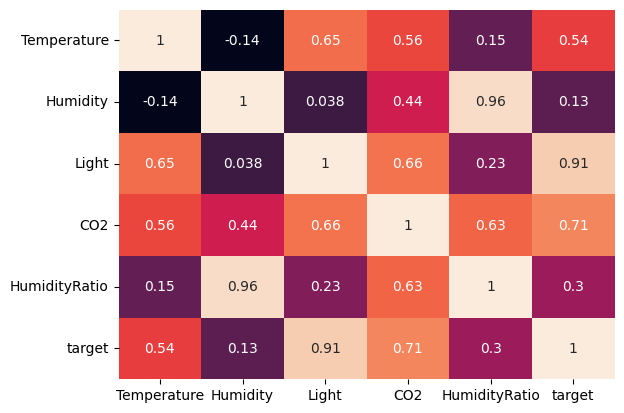

In [ ]:
sns.heatmap(dataset.corr(), annot=True, cbar=False)
dataset.describe()
y = dataset['target'].values
X = dataset.drop(columns=['target']).values

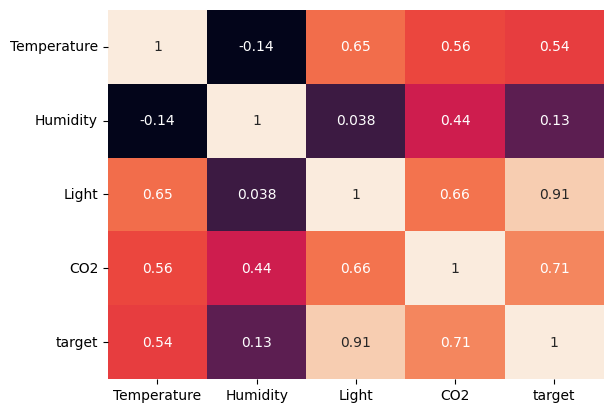

In [ ]:
#dataset.drop('date', axis=1, inplace=True)
dataset.drop(['HumidityRatio', 'date'], axis=1, inplace=True)
sns.heatmap(dataset.corr(), annot=True, cbar=False)
dataset.describe()
y = dataset['target'].values
X = dataset.drop(columns=['target']).values


In [ ]:
dataset

Temperature  Humidity  Light         CO2  target
0           23.18   27.2720  426.0  721.250000       1
1           23.15   27.2675  429.5  714.000000       1
2           23.15   27.2450  426.0  713.500000       1
3           23.15   27.2000  426.0  708.250000       1
4           23.10   27.2000  426.0  704.500000       1
...           ...       ...    ...         ...     ...
8138        21.05   36.0975  433.0  787.250000       1
8139        21.05   35.9950  433.0  789.500000       1
8140        21.10   36.0950  433.0  798.500000       1
8141        21.10   36.2600  433.0  820.333333       1
8142        21.10   36.2000  447.0  821.000000       1

[8143 rows x 5 columns]

#### Resposta
Implementei a visualização da matriz de covariância para analisar a necessidade de maneter algumas variáveis e remover outras, que pudessem tornar o treinamento da rede mais lento.
Com essa visualização, julguei válido remover a variável 'HumidityRatio', visto que ela é resultado de outras 2 variáveis que já estão presentes no dataset.

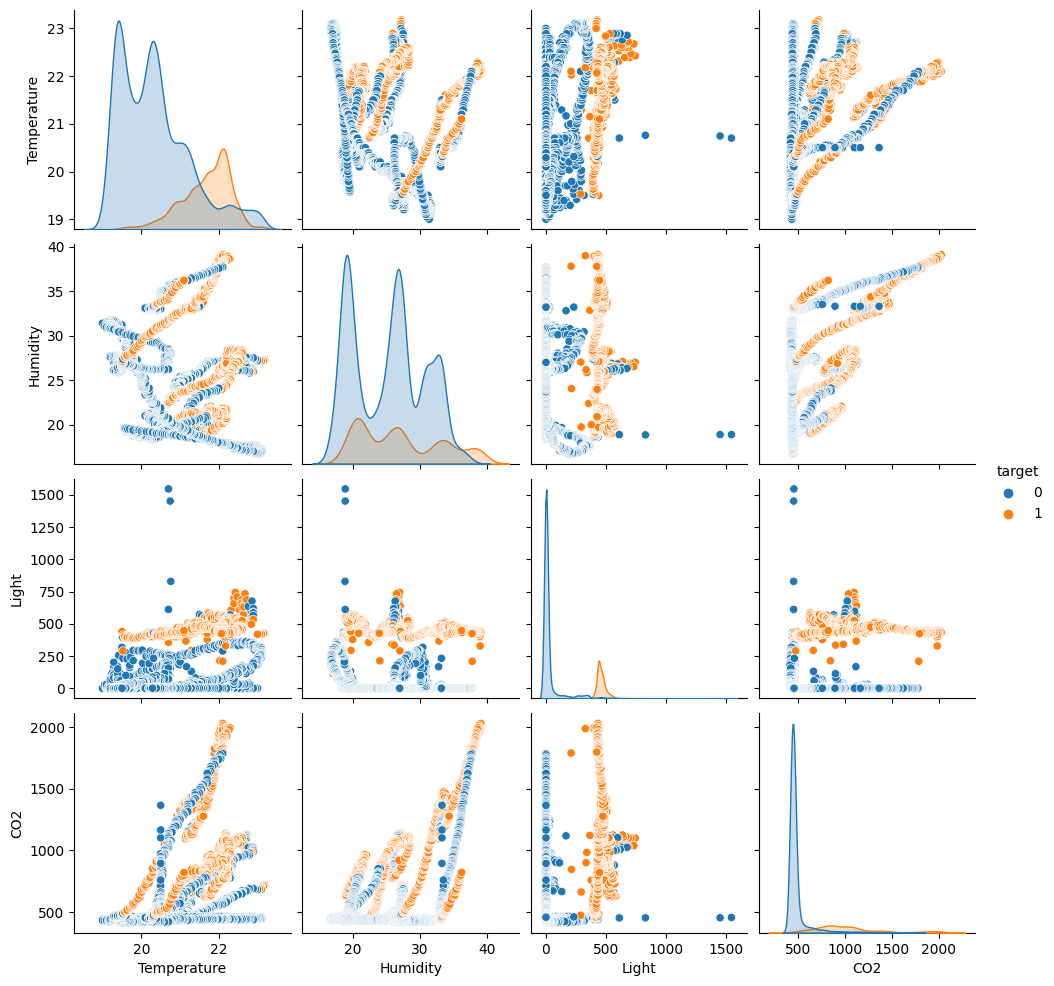

In [ ]:
sns.pairplot(dataset, hue="target", diag_kind="kde")

## Parte II. Treinamento do modelo de Rede Neural - Baseline 

Total: 1,0 pts.

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

A acurácia: representando a porcentagem de elementos classificados corretamente (positivos ou negativos), indica uma performance geral do modelo

A precisão: que define, dentre os exemplos classificados como positivos (pelo modelo), quantos eram realmente verdadeiros. Ela é utilizada onde os falsos positivos são considerados mais prejudiciais que os falsos negativos. Por exemplo: é pior classificar um investimento ruim como bom, do que classificar um investimento bom como ruim;
(valor é 1 e marcou 1)

  Recall: que define, dentre todas as situações de classe positiva (dos valores esperados), quantas foram classificadas como verdadeiras. Ela é utilizada onde os falsos negativos são considerados mais prejudiciais que os falsos positivos. Por exemplo: é bem pior classificar uma pessoa doente como saudável, do que classificar uma pessoa saudável como doente, considerando doente igual a positivo;
(falso positivo)

A especificidade: que é a porcentagem de amostras negativas identificadas corretamente sobre o total de amostras negativas;

E o F-Score ou F-Measure: que representa a média ponderada de precisão e revocação.


In [ ]:
new_df = transform_data(dataset, normalize=False)
#new_df.head()
#transform_data ja sabe como se comportar em relacao a variavel target, ent nn precisa se preocupar 

In [ ]:
new_df.head()

Temperature  Humidity  Light     CO2  target
0        23.18   27.2720  426.0  721.25       1
1        23.15   27.2675  429.5  714.00       1
2        23.15   27.2450  426.0  713.50       1
3        23.15   27.2000  426.0  708.25       1
4        23.10   27.2000  426.0  704.50       1

In [ ]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [ ]:
#batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 
epochs = 170  #numero maximo de ciclos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:

#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())



In [ ]:
#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
train_dataset.X_data

tensor([[  21.7000,   20.3900,  512.7500,  804.0000],
        [  19.6500,   19.3400,    0.0000,  446.0000],
        [  22.9725,   16.7900,  181.5000,  444.0000],
        ...,
        [  22.2000,   38.4333,  429.5000, 1943.5000],
        [  21.2675,   32.9500,   13.0000, 1159.7500],
        [  22.4633,   28.3267,  527.0000, 1081.3334]])

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [ ]:
lr = 0.01 #taxa de aprendizado
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.150 | Val Loss: 0.6114 | Train Acc: 67.0184| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.588 | Val Loss: 0.5600 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.555 | Val Loss: 0.5351 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.538 | Val Loss: 0.5223 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.530 | Val Loss: 0.5154 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.526 | Val Loss: 0.5115 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.524 | Val Loss: 0.5093 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.522 | Val Loss: 0.5079 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.522 | Val Loss: 0.5071 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.521 | Val Loss: 0.5066 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.521 | Val Loss: 0.5062 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

In [ ]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
           1       0.00      0.00      0.00       343

    accuracy                           0.79      1629
   macro avg       0.39      0.50      0.44      1629
weighted avg       0.62      0.79      0.70      1629



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


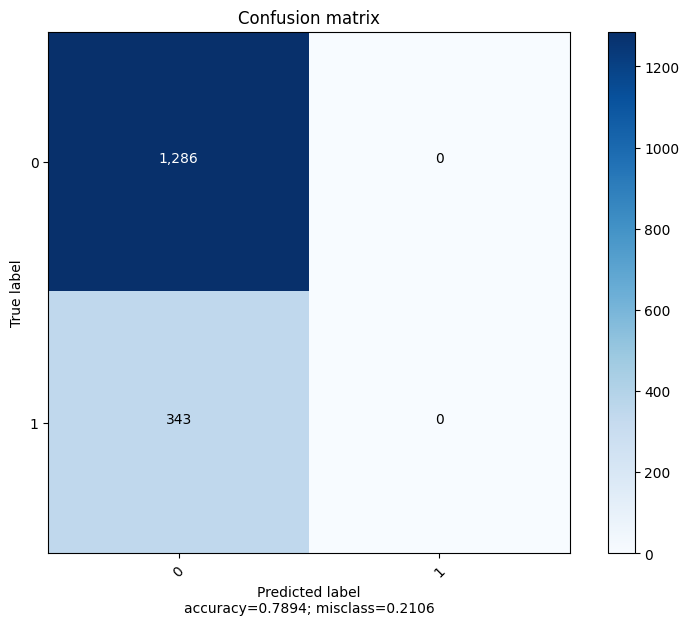

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta
O primeiro fato que analisei ao rodar a rede sem normalizar, foi a estagnação dos dados (Train Loss, Validation Loss, Train Accuracy, Validation Accuracy). Essa estagnação se justifica pela carencia da normalização dos dados, onde nesse caso, a rede entendeu que certas variáveis tem pesos maiores que outras, definindos os pesos das varíaveis por ordem de grandeza dos valores e não pela sua verdadeira importância no treinamento da rede. Tal fato justifica a taxa de acurácia, visto que a variável 'light' tem uma das maiores grandezas escalares, e um alto grau de correlação com o 'target'.
Na análise dos dados percebi que a rede não conseguiu/tentou prever a situacao 'target'== 1.

## Parte III - Mudança de configurações do modelo

Total: 8,0 pts.

### 1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [ ]:
new_df = transform_data(dataset, normalize=True)
new_df.head()

A saída de streaming foi truncada nas últimas 5000 linhas.
/content/PUC_Redes_Neurais/grad/lista 1/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
/content/PUC_Redes_Neurais/grad/lista 1/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
/content/PUC_Redes_Neurais/grad/lista 1/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

date_2015-02-04 17:51:00  date_2015-02-04 17:51:59  \
0                         1                         0   
1                         0                         1   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   date_2015-02-04 17:53:00  date_2015-02-04 17:54:00  \
0                         0                         0   
1                         0                         0   
2                         1                         0   
3                         0                         1   
4                         0                         0   

   date_2015-02-04 17:55:00  date_2015-02-04 17:55:59  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         1                         0   

   date_2015-02-04 17:57:00  date_2015-02-04 17:57:59  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   date_2015-02-04 17:58:59  date_2015-02-04 18:00:00  ...  \
0                         0                         0  ...   
1                         0                         0  ...   
2                         0                         0  ...   
3                         0                         0  ...   
4                         0                         0  ...   

   date_2015-02-10 09:29:59  date_2015-02-10 09:30:59  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   date_2015-02-10 09:32:00  date_2015-02-10 09:33:00  Temperature  Humidity  \
0                         0                         0     1.000000  0.470533   
1                         0                         0     0.992823  0.470332   
2                         0                         0     0.992823  0.469326   
3                         0                         0     0.992823  0.467315   
4                         0                         0     0.980861  0.467315   

      Light       CO2  HumidityRatio  target  
0  0.275490  0.190933       0.557318       1  
1  0.277754  0.186446       0.554807       1  
2  0.275490  0.186136       0.553761       1  
3  0.275490  0.182887       0.551669       1  
4  0.275490  0.180566       0.547851       1  

[5 rows x 8149 columns]

In [ ]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [ ]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.582 | Val Loss: 0.5521 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.551 | Val Loss: 0.5317 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.538 | Val Loss: 0.5215 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.531 | Val Loss: 0.5144 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.525 | Val Loss: 0.5081 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.519 | Val Loss: 0.5018 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.512 | Val Loss: 0.4950 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.505 | Val Loss: 0.4872 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.497 | Val Loss: 0.4780 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.486 | Val Loss: 0.4669 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.474 | Val Loss: 0.4533 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

#### Resposta

In [ ]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1286
           1       0.95      1.00      0.97       343

    accuracy                           0.99      1629
   macro avg       0.97      0.99      0.98      1629
weighted avg       0.99      0.99      0.99      1629



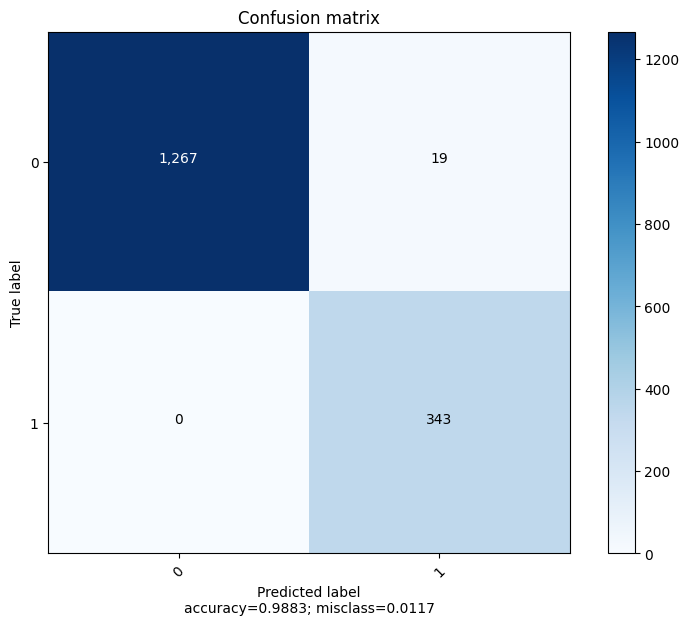

In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

Com a rede normalizada, a acurácia aumentou significativamente, além do F1 score, mostrando que o balanceamento dos pesos agregou positivamente para a rede. Tal melhora se mostrou clara na matriz de confusão, onde a rede começou a marcar acertivamente positivo->positivo, aumentando a precisão da rede e consequentemente o F1 score.

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

##### Epoch = 1

Binary classification


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.639 | Val Loss: 0.5808 | Train Acc: 71.5276| Val Acc: 80.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
           1       0.00      0.00      0.00       343

    accuracy                           0.79      1629
   macro avg       0.39      0.50      0.44      1629
weighted avg       0.62      0.79      0.70      1629



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


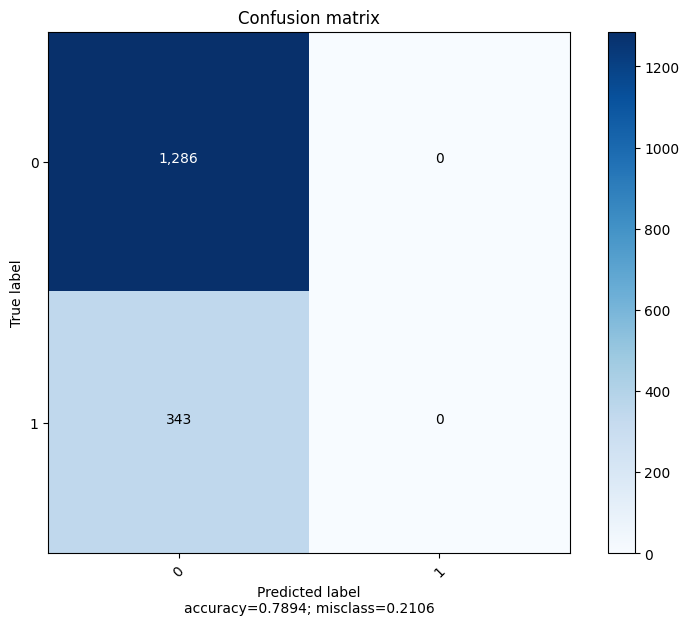

In [ ]:
epochs = 1 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 2

Binary classification


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.545 | Val Loss: 0.5261 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.532 | Val Loss: 0.5146 | Train Acc: 78.4785| Val Acc: 80.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
           1       0.00      0.00      0.00       343

    accuracy                           0.79      1629
   macro avg       0.39      0.50      0.44      1629
weighted avg       0.62      0.79      0.70      1629



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


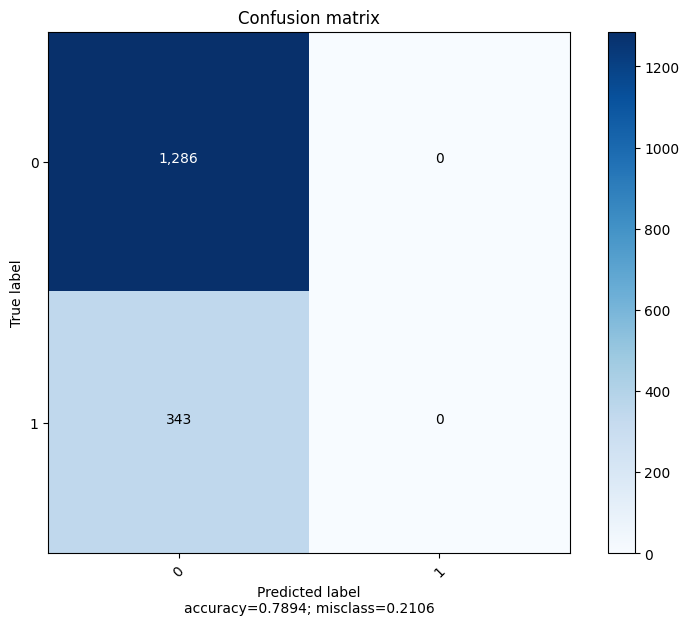

In [ ]:
epochs = 2 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 3

Binary classification


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.585 | Val Loss: 0.5492 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.546 | Val Loss: 0.5253 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.530 | Val Loss: 0.5108 | Train Acc: 78.4785| Val Acc: 80.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
           1       0.00      0.00      0.00       343

    accuracy                           0.79      1629
   macro avg       0.39      0.50      0.44      1629
weighted avg       0.62      0.79      0.70      1629



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


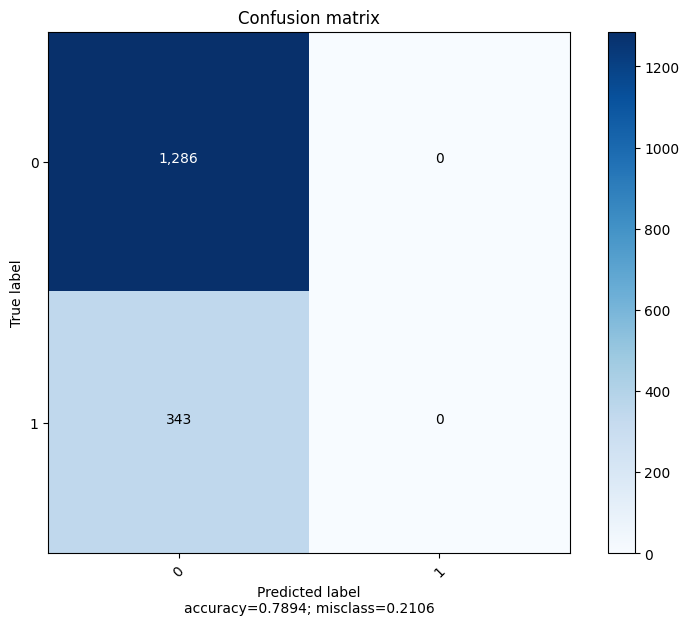

In [ ]:
epochs = 3 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 4

Binary classification


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.576 | Val Loss: 0.5508 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.548 | Val Loss: 0.5303 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.535 | Val Loss: 0.5195 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.528 | Val Loss: 0.5131 | Train Acc: 78.4785| Val Acc: 80.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
           1       0.00      0.00      0.00       343

    accuracy                           0.79      1629
   macro avg       0.39      0.50      0.44      1629
weighted avg       0.62      0.79      0.70      1629



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


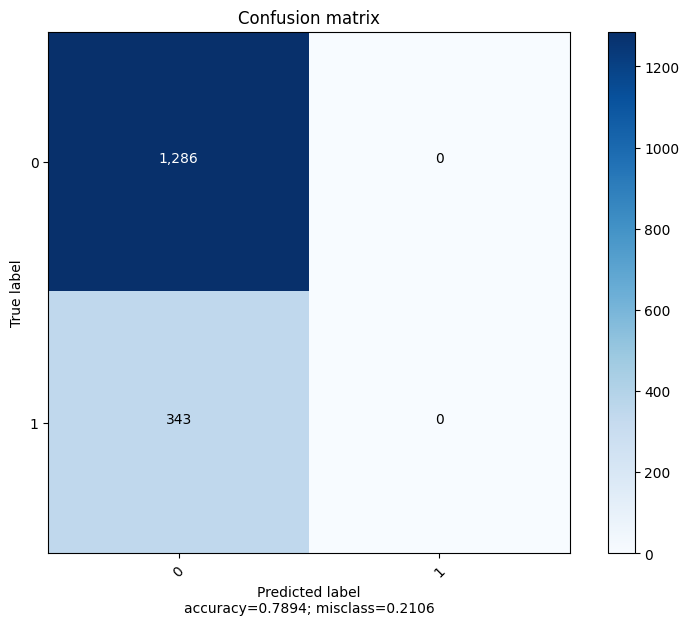

In [ ]:
epochs = 4 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 5

Binary classification


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.703 | Val Loss: 0.6250 | Train Acc: 49.2883| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.591 | Val Loss: 0.5547 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.550 | Val Loss: 0.5278 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.534 | Val Loss: 0.5146 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.524 | Val Loss: 0.5053 | Train Acc: 78.4785| Val Acc: 80.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
           1       0.00      0.00      0.00       343

    accuracy                           0.79      1629
   macro avg       0.39      0.50      0.44      1629
weighted avg       0.62      0.79      0.70      1629



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


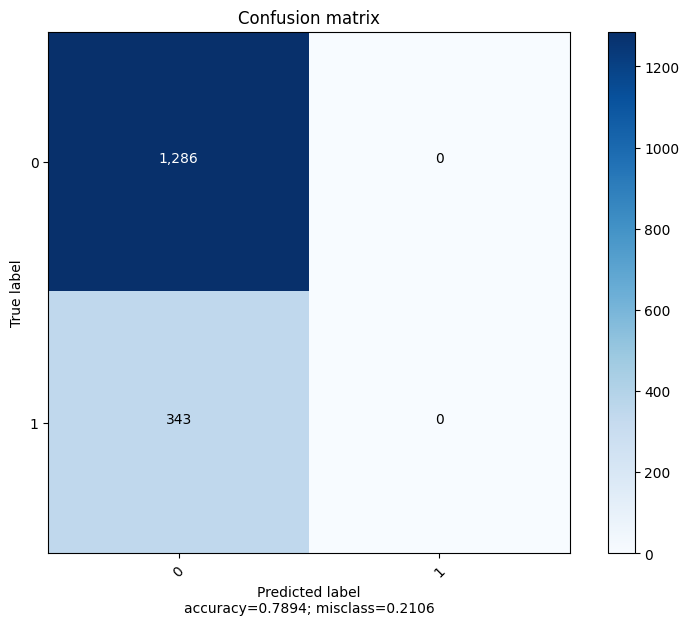

In [ ]:
epochs = 5 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 10

Binary classification


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.607 | Val Loss: 0.5576 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.546 | Val Loss: 0.5190 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.522 | Val Loss: 0.5011 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.509 | Val Loss: 0.4883 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.497 | Val Loss: 0.4758 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.484 | Val Loss: 0.4619 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.469 | Val Loss: 0.4478 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.456 | Val Loss: 0.4337 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.441 | Val Loss: 0.4185 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.425 | Val Loss: 0.4027 | Train Acc: 78.4785| Val Acc: 80.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1286
 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


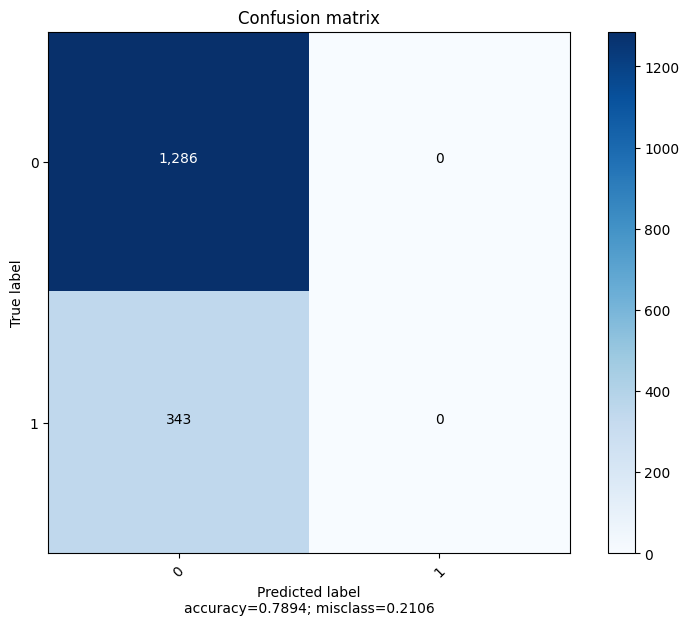

In [ ]:
epochs = 10
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 50

Binary classification


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.579 | Val Loss: 0.5251 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.510 | Val Loss: 0.4833 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.484 | Val Loss: 0.4634 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.468 | Val Loss: 0.4478 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.452 | Val Loss: 0.4311 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.434 | Val Loss: 0.4129 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.416 | Val Loss: 0.3954 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.399 | Val Loss: 0.3784 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.382 | Val Loss: 0.3625 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.366 | Val Loss: 0.3475 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.351 | Val Loss: 0.3330 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

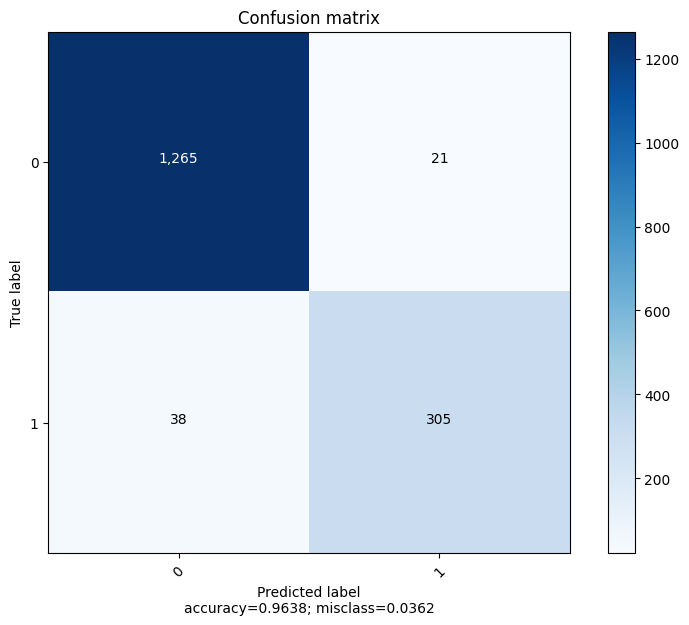

In [ ]:
epochs = 50
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 100

Binary classification


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.759 | Val Loss: 0.6392 | Train Acc: 37.6687| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.583 | Val Loss: 0.5335 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.518 | Val Loss: 0.4911 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.491 | Val Loss: 0.4696 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.473 | Val Loss: 0.4529 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.457 | Val Loss: 0.4355 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.439 | Val Loss: 0.4187 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.423 | Val Loss: 0.4029 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.408 | Val Loss: 0.3878 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.393 | Val Loss: 0.3734 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.379 | Val Loss: 0.3596 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

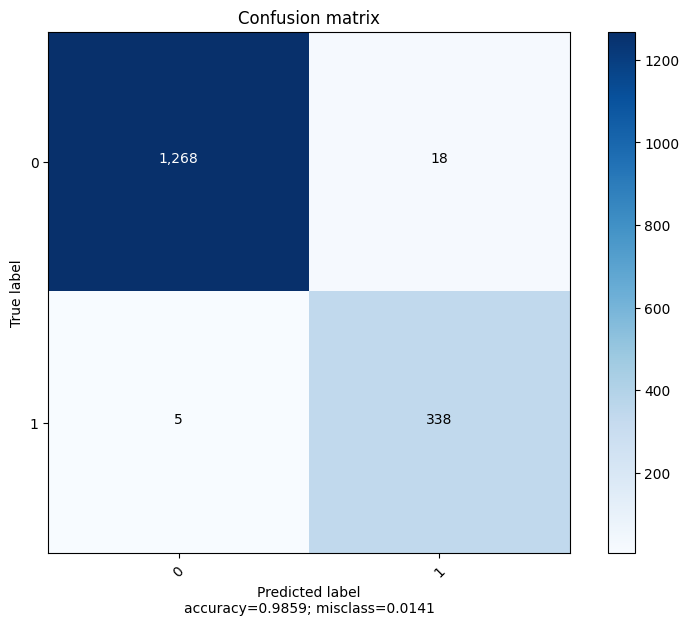

In [ ]:
epochs = 100
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 500

Binary classification


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.598 | Val Loss: 0.5563 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.545 | Val Loss: 0.5214 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.522 | Val Loss: 0.5033 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.509 | Val Loss: 0.4903 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.497 | Val Loss: 0.4783 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.485 | Val Loss: 0.4669 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.474 | Val Loss: 0.4554 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.463 | Val Loss: 0.4435 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.451 | Val Loss: 0.4311 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.438 | Val Loss: 0.4180 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.424 | Val Loss: 0.4044 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

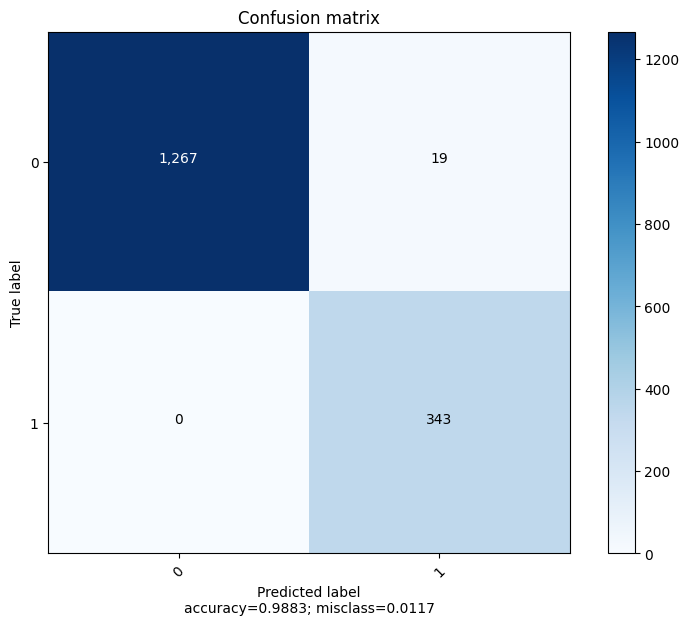

In [ ]:
epochs = 500 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### Epochs = 1000

Binary classification


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.602 | Val Loss: 0.5589 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.542 | Val Loss: 0.5136 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.510 | Val Loss: 0.4894 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.493 | Val Loss: 0.4739 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.480 | Val Loss: 0.4612 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.468 | Val Loss: 0.4490 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.456 | Val Loss: 0.4361 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.442 | Val Loss: 0.4223 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.428 | Val Loss: 0.4077 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.413 | Val Loss: 0.3920 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.396 | Val Loss: 0.3751 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

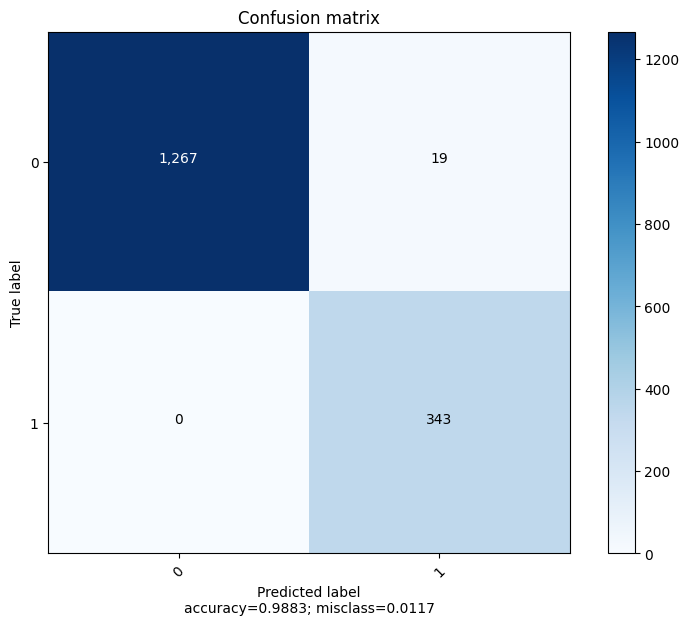

In [ ]:
epochs = 1000 
new_df = transform_data(dataset, normalize=True)
new_df.head()
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

  Com epochs = {1, 2, 3, 4, 5, 10} a acurácia da rede, F1-score, recall e precisão tiveram resultados baixíssimos. Tal resultado pode se justificar porque a rede não teve épocas o suficiente para aprender sobre todos os parâmetros da rede, caracterizando underfitting da rede.
  Já com epochs = {50}, houve uma melhora drástica na rede, principalmente em relação ao recall, onde a rede começou a aprender a detectar pessoas no cômodo, onde antes a taxa de acerto quando target = 1 era muito baixa e agora ela começou a acertar.
  Em relação aos valores de epochs = {100, 500, 1000} os resultados foram iguais, mesmo com a rede demorando muito para estagnar, cogitei que tenha ocorrido overfitting da rede, porém mesmo com uma diferença pequena, a rede continuou melhorando.

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

##### lr = 0,001

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.558 | Val Loss: 0.5479 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.553 | Val Loss: 0.5433 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.549 | Val Loss: 0.5391 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.545 | Val Loss: 0.5352 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.542 | Val Loss: 0.5317 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.539 | Val Loss: 0.5284 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 007: | Train Loss: 0.536 | Val Loss: 0.5254 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 008: | Train Loss: 0.533 | Val Loss: 0.5226 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 009: | Train Loss: 0.531 | Val Loss: 0.5200 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 010: | Train Loss: 0.529 | Val Loss: 0.5177 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 011: | Train Loss: 0.527 | Val Loss: 0.5155 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 012: | Train Lo

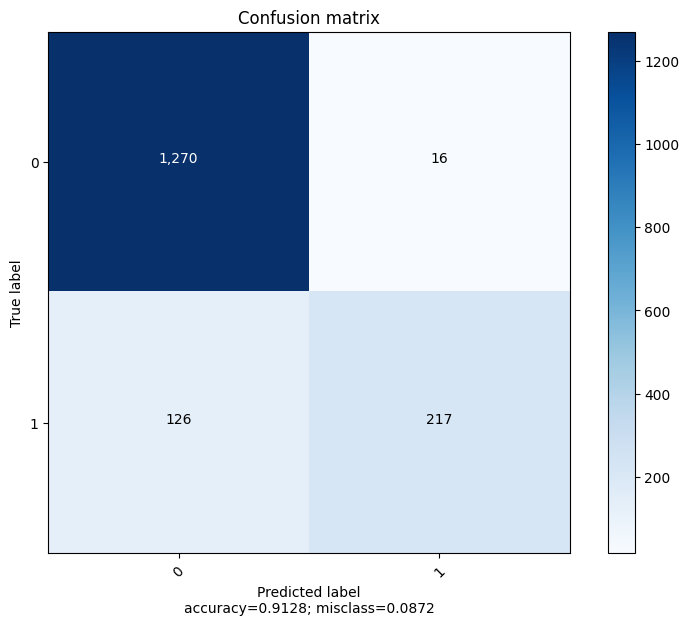

In [ ]:
lr = 0.001 #taxa de aprendizado
epochs = 250 #numero maximo de ciclos
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')


history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### lr = 0,05


Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.535 | Val Loss: 0.4700 | Train Acc: 78.1902| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.436 | Val Loss: 0.3693 | Train Acc: 78.8957| Val Acc: 82.0000
Epoch 003: | Train Loss: 0.325 | Val Loss: 0.2672 | Train Acc: 84.3620| Val Acc: 89.0000
Epoch 004: | Train Loss: 0.240 | Val Loss: 0.2055 | Train Acc: 91.7669| Val Acc: 93.0000
Epoch 005: | Train Loss: 0.192 | Val Loss: 0.1723 | Train Acc: 94.3804| Val Acc: 94.0000
Epoch 006: | Train Loss: 0.164 | Val Loss: 0.1520 | Train Acc: 95.1411| Val Acc: 95.0000
Epoch 007: | Train Loss: 0.146 | Val Loss: 0.1378 | Train Acc: 95.7301| Val Acc: 95.0000
Epoch 008: | Train Loss: 0.131 | Val Loss: 0.1266 | Train Acc: 96.0675| Val Acc: 95.0000
Epoch 009: | Train Loss: 0.120 | Val Loss: 0.1175 | Train Acc: 96.1779| Val Acc: 96.0000
Epoch 010: | Train Loss: 0.110 | Val Loss: 0.1098 | Train Acc: 96.5460| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.102 | Val Loss: 0.1033 | Train Acc: 96.8221| Val Acc: 97.0000
Epoch 012: | Train Lo

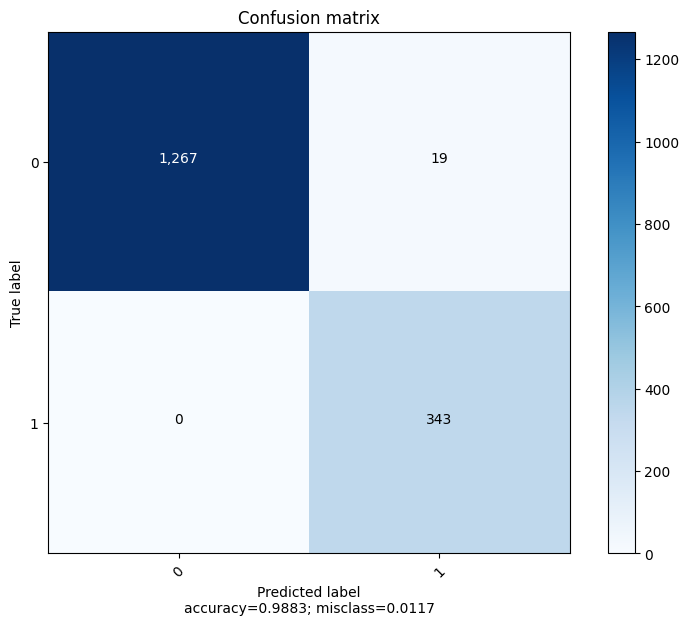

In [ ]:
lr = 0.05 #taxa de aprendizado
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### lr = 0,07

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.551 | Val Loss: 0.5064 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.515 | Val Loss: 0.4917 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.493 | Val Loss: 0.4547 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.437 | Val Loss: 0.3821 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.354 | Val Loss: 0.3005 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 006: | Train Loss: 0.278 | Val Loss: 0.2371 | Train Acc: 84.6564| Val Acc: 91.0000
Epoch 007: | Train Loss: 0.222 | Val Loss: 0.1932 | Train Acc: 93.5583| Val Acc: 94.0000
Epoch 008: | Train Loss: 0.183 | Val Loss: 0.1624 | Train Acc: 95.0061| Val Acc: 95.0000
Epoch 009: | Train Loss: 0.155 | Val Loss: 0.1402 | Train Acc: 95.9202| Val Acc: 96.0000
Epoch 010: | Train Loss: 0.134 | Val Loss: 0.1237 | Train Acc: 96.3436| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.118 | Val Loss: 0.1111 | Train Acc: 96.6380| Val Acc: 97.0000
Epoch 012: | Train Lo

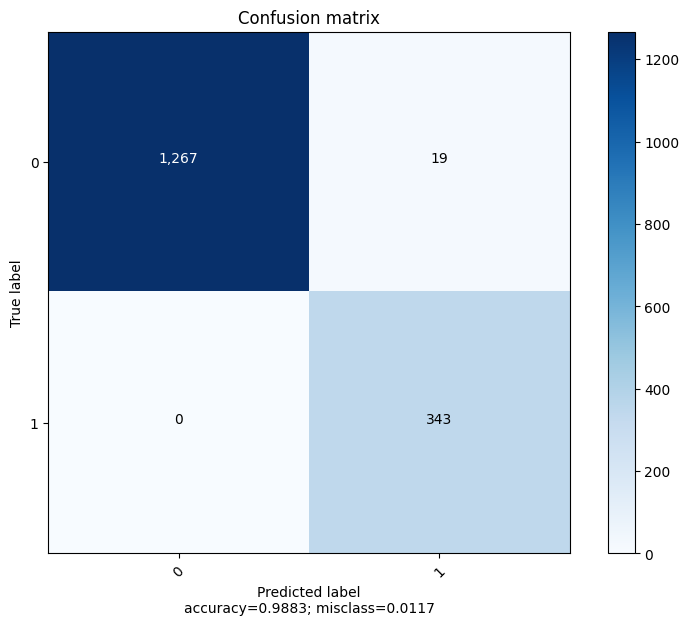

In [ ]:
lr = 0.07 #taxa de aprendizado
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### lr = 0,1

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.521 | Val Loss: 0.4274 | Train Acc: 76.8037| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.338 | Val Loss: 0.2392 | Train Acc: 84.9264| Val Acc: 92.0000
Epoch 003: | Train Loss: 0.200 | Val Loss: 0.1642 | Train Acc: 94.2577| Val Acc: 95.0000
Epoch 004: | Train Loss: 0.149 | Val Loss: 0.1336 | Train Acc: 95.7178| Val Acc: 95.0000
Epoch 005: | Train Loss: 0.123 | Val Loss: 0.1149 | Train Acc: 96.2147| Val Acc: 96.0000
Epoch 006: | Train Loss: 0.105 | Val Loss: 0.1018 | Train Acc: 96.8037| Val Acc: 97.0000
Epoch 007: | Train Loss: 0.092 | Val Loss: 0.0924 | Train Acc: 97.2331| Val Acc: 97.0000
Epoch 008: | Train Loss: 0.082 | Val Loss: 0.0857 | Train Acc: 97.6012| Val Acc: 97.0000
Epoch 009: | Train Loss: 0.075 | Val Loss: 0.0810 | Train Acc: 98.0429| Val Acc: 98.0000
Epoch 010: | Train Loss: 0.070 | Val Loss: 0.0777 | Train Acc: 98.3742| Val Acc: 98.0000
Epoch 011: | Train Loss: 0.066 | Val Loss: 0.0755 | Train Acc: 98.6687| Val Acc: 98.0000
Epoch 012: | Train Lo

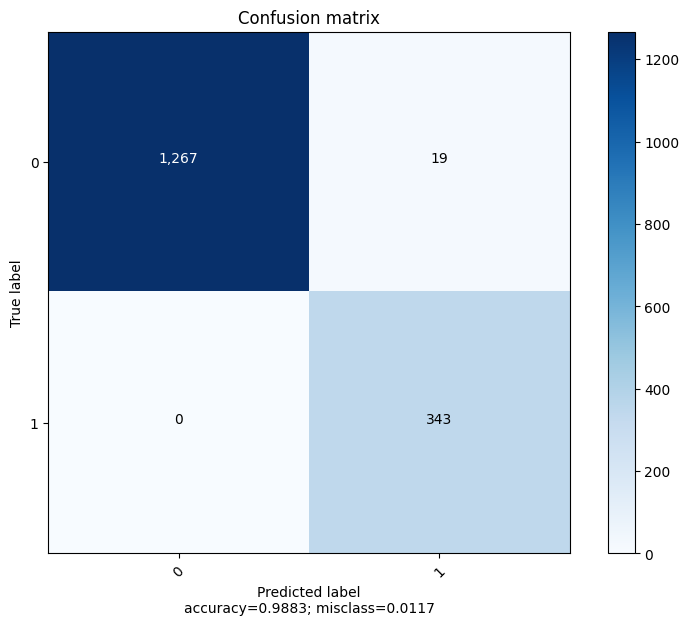

In [ ]:
lr = 0.1 #taxa de aprendizado
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### lr = 0,9


A saída de streaming foi truncada nas últimas 5000 linhas.
/content/PUC_Redes_Neurais/grad/lista 1/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
/content/PUC_Redes_Neurais/grad/lista 1/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
/content/PUC_Redes_Neurais/grad/lista 1/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.232 | Val Loss: 0.0843 | Train Acc: 90.4356| Val Acc: 98.0000
Epoch 002: | Train Loss: 0.060 | Val Loss: 0.0652 | Train Acc: 98.4847| Val Acc: 98.0000
Epoch 003: | Train Loss: 0.043 | Val Loss: 0.0639 | Train Acc: 98.9325| Val Acc: 98.0000
Epoch 004: | Train Loss: 0.036 | Val Loss: 0.0635 | Train Acc: 99.0982| Val Acc: 98.0000
Epoch 005: | Train Loss: 0.031 | Val Loss: 0.0634 | Train Acc: 99.3742| Val Acc: 98.0000
Epoch 006: | Train Loss: 0.028 | Val Loss: 0.0634 | Train Acc: 99.4663| Val Acc: 98.0000
Epoch 007: | Train Loss: 0.026 | Val Loss: 0.0636 | Train Acc: 99.5031| Val Acc: 98.0000
Epoch 008: | Train Loss: 0.025 | Val Loss: 0.0638 | Train Acc: 99.5215| Val Acc: 98.0000
Epoch 009: | Train Loss: 0.024 | Val Loss: 0.0641 | Train Acc: 99.5215| Val Acc: 98.0000
Epoch 010: | Train Loss: 0.023 | Val Loss: 0.0642 | Train Acc: 99.5215| Val Acc: 98.0000
Epoch 011: | Train Loss: 0.022 | Val Loss: 0.0644 | Train Acc: 99.5215| Val Acc: 98.0000
Epoch 012: | Train Lo

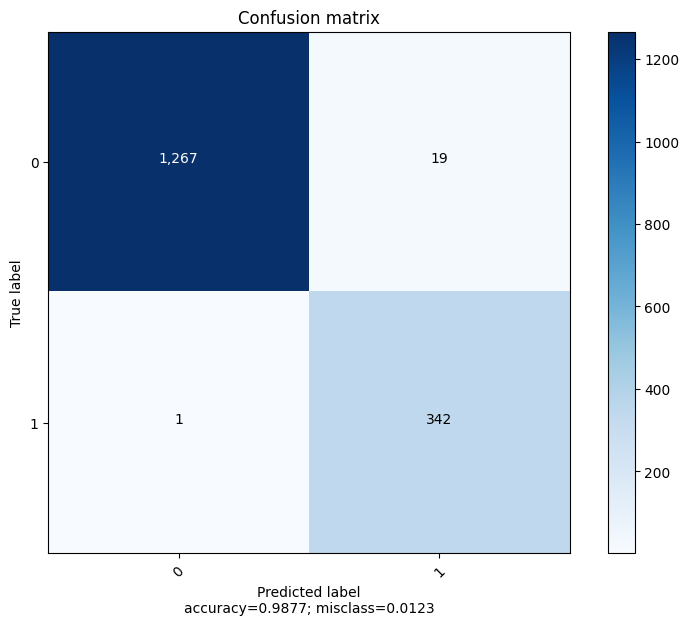

In [ ]:
lr = 1 #taxa de aprendizado
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

Com uma taxa de aprendizado muito pequena, pude observar uma taxa de perda muito alta. Tal fato se relaciona à rede não ter achado o minímo global, devido ao valor da taxa de aprendizado ser muito pequeno.
Quando aumentei para 0,05, todos os valores da rede melhoraram, principalmente o recall para positivos, que por consequência melhorou o F1-score.
Com os valores que utilizei, não consegui notar uma grande diferença entre a taxa de aprendizado = {0,05, 0,07 e 0,1}. A única melhora perceptível foi em relação a acurácia de treinamento que aumentou, e a perda de validação que diminuiu, porém ambos de maneira não tão significativa. 


### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

##### hidden_neurons = 6

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.560 | Val Loss: 0.4977 | Train Acc: 77.2638| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.473 | Val Loss: 0.4132 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.365 | Val Loss: 0.2949 | Train Acc: 82.0245| Val Acc: 88.0000
Epoch 004: | Train Loss: 0.259 | Val Loss: 0.2170 | Train Acc: 90.9387| Val Acc: 93.0000
Epoch 005: | Train Loss: 0.201 | Val Loss: 0.1784 | Train Acc: 94.2638| Val Acc: 94.0000
Epoch 006: | Train Loss: 0.170 | Val Loss: 0.1563 | Train Acc: 94.9018| Val Acc: 95.0000
Epoch 007: | Train Loss: 0.150 | Val Loss: 0.1412 | Train Acc: 95.7485| Val Acc: 95.0000
Epoch 008: | Train Loss: 0.135 | Val Loss: 0.1296 | Train Acc: 96.0491| Val Acc: 96.0000
Epoch 009: | Train Loss: 0.123 | Val Loss: 0.1199 | Train Acc: 96.1595| Val Acc: 96.0000
Epoch 010: | Train Loss: 0.113 | Val Loss: 0.1119 | Train Acc: 96.4356| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.105 | Val Loss: 0.1050 | Train Acc: 96.8221| Val Acc: 97.0000
Epoch 012: | Train Lo

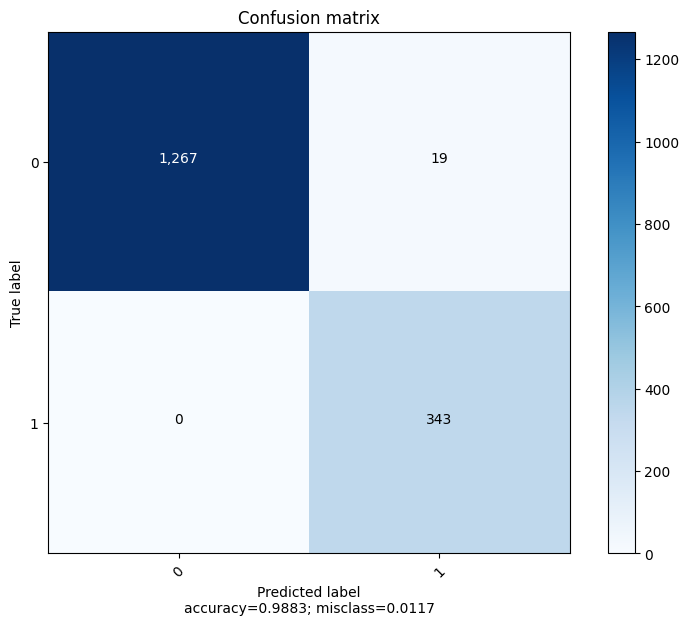

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 6
epochs = 250 #numero maximo de ciclos

new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 3

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.571 | Val Loss: 0.4819 | Train Acc: 71.3865| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.457 | Val Loss: 0.4081 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.386 | Val Loss: 0.3442 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.325 | Val Loss: 0.2890 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.273 | Val Loss: 0.2443 | Train Acc: 86.2883| Val Acc: 91.0000
Epoch 006: | Train Loss: 0.233 | Val Loss: 0.2101 | Train Acc: 93.1902| Val Acc: 93.0000
Epoch 007: | Train Loss: 0.201 | Val Loss: 0.1837 | Train Acc: 94.7975| Val Acc: 95.0000
Epoch 008: | Train Loss: 0.177 | Val Loss: 0.1635 | Train Acc: 95.4724| Val Acc: 95.0000
Epoch 009: | Train Loss: 0.158 | Val Loss: 0.1478 | Train Acc: 95.7546| Val Acc: 95.0000
Epoch 010: | Train Loss: 0.143 | Val Loss: 0.1352 | Train Acc: 96.0859| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.131 | Val Loss: 0.1249 | Train Acc: 96.3067| Val Acc: 96.0000
Epoch 012: | Train Lo

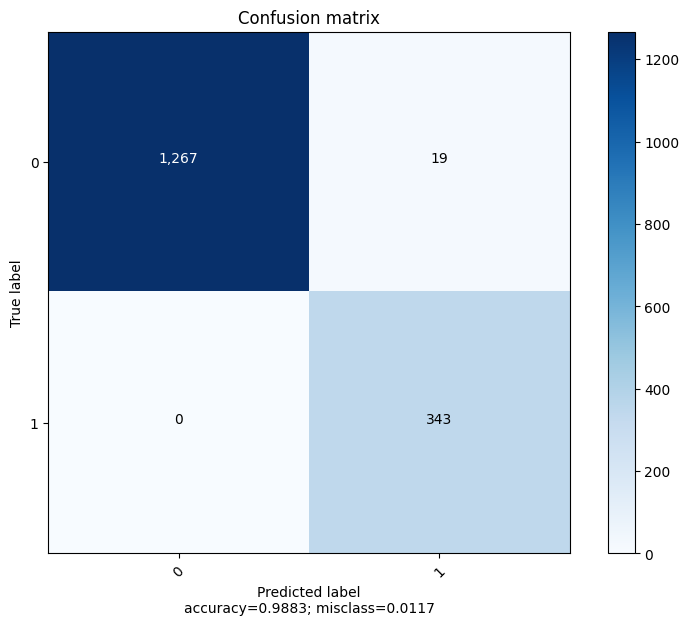

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 3
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 4

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.593 | Val Loss: 0.5132 | Train Acc: 70.8712| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.513 | Val Loss: 0.4876 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.482 | Val Loss: 0.4406 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.412 | Val Loss: 0.3561 | Train Acc: 80.4601| Val Acc: 84.0000
Epoch 005: | Train Loss: 0.327 | Val Loss: 0.2841 | Train Acc: 87.3252| Val Acc: 90.0000
Epoch 006: | Train Loss: 0.266 | Val Loss: 0.2366 | Train Acc: 91.5460| Val Acc: 92.0000
Epoch 007: | Train Loss: 0.225 | Val Loss: 0.2048 | Train Acc: 93.8773| Val Acc: 94.0000
Epoch 008: | Train Loss: 0.197 | Val Loss: 0.1824 | Train Acc: 94.7485| Val Acc: 94.0000
Epoch 009: | Train Loss: 0.176 | Val Loss: 0.1653 | Train Acc: 95.3436| Val Acc: 95.0000
Epoch 010: | Train Loss: 0.160 | Val Loss: 0.1514 | Train Acc: 95.8466| Val Acc: 95.0000
Epoch 011: | Train Loss: 0.146 | Val Loss: 0.1399 | Train Acc: 96.0307| Val Acc: 95.0000
Epoch 012: | Train Lo

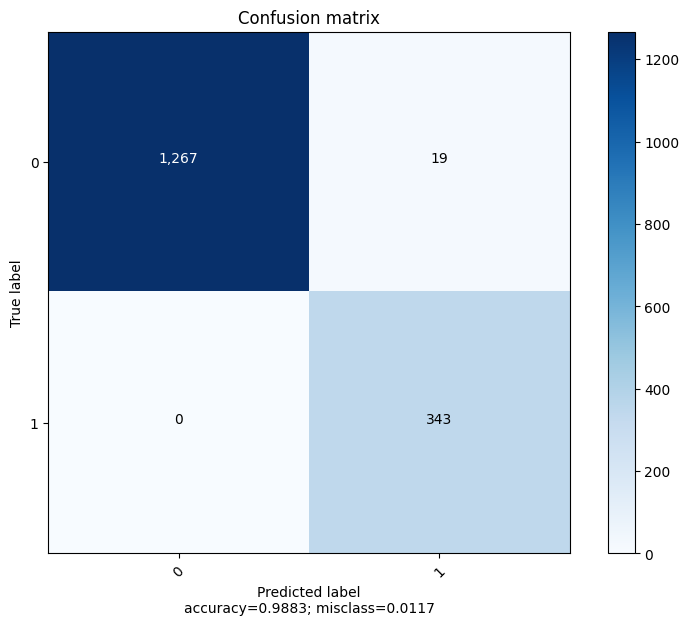

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 4
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 1

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.549 | Val Loss: 0.4939 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.475 | Val Loss: 0.4314 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.413 | Val Loss: 0.3682 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.347 | Val Loss: 0.3057 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.287 | Val Loss: 0.2536 | Train Acc: 79.9141| Val Acc: 89.0000
Epoch 006: | Train Loss: 0.239 | Val Loss: 0.2137 | Train Acc: 92.2638| Val Acc: 93.0000
Epoch 007: | Train Loss: 0.203 | Val Loss: 0.1838 | Train Acc: 94.8773| Val Acc: 94.0000
Epoch 008: | Train Loss: 0.176 | Val Loss: 0.1611 | Train Acc: 95.6564| Val Acc: 95.0000
Epoch 009: | Train Loss: 0.155 | Val Loss: 0.1437 | Train Acc: 96.0123| Val Acc: 95.0000
Epoch 010: | Train Loss: 0.138 | Val Loss: 0.1301 | Train Acc: 96.4172| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.125 | Val Loss: 0.1193 | Train Acc: 96.6748| Val Acc: 97.0000
Epoch 012: | Train Lo

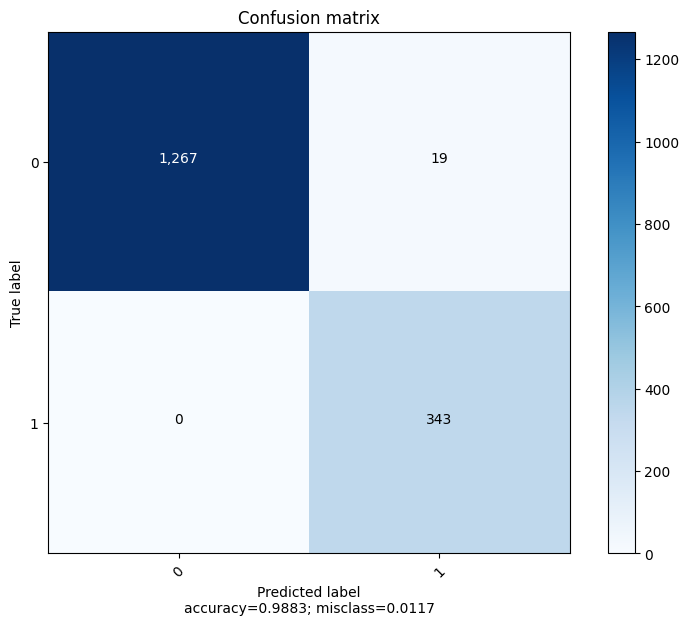

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 1
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 2

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.599 | Val Loss: 0.5147 | Train Acc: 70.2515| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.509 | Val Loss: 0.4768 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 003: | Train Loss: 0.459 | Val Loss: 0.4084 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 004: | Train Loss: 0.371 | Val Loss: 0.3160 | Train Acc: 83.2454| Val Acc: 89.0000
Epoch 005: | Train Loss: 0.287 | Val Loss: 0.2477 | Train Acc: 91.2945| Val Acc: 93.0000
Epoch 006: | Train Loss: 0.230 | Val Loss: 0.2035 | Train Acc: 93.7362| Val Acc: 94.0000
Epoch 007: | Train Loss: 0.192 | Val Loss: 0.1741 | Train Acc: 94.4908| Val Acc: 95.0000
Epoch 008: | Train Loss: 0.166 | Val Loss: 0.1536 | Train Acc: 95.3926| Val Acc: 95.0000
Epoch 009: | Train Loss: 0.147 | Val Loss: 0.1383 | Train Acc: 95.9571| Val Acc: 96.0000
Epoch 010: | Train Loss: 0.132 | Val Loss: 0.1265 | Train Acc: 96.2331| Val Acc: 96.0000
Epoch 011: | Train Loss: 0.120 | Val Loss: 0.1169 | Train Acc: 96.4356| Val Acc: 96.0000
Epoch 012: | Train Lo

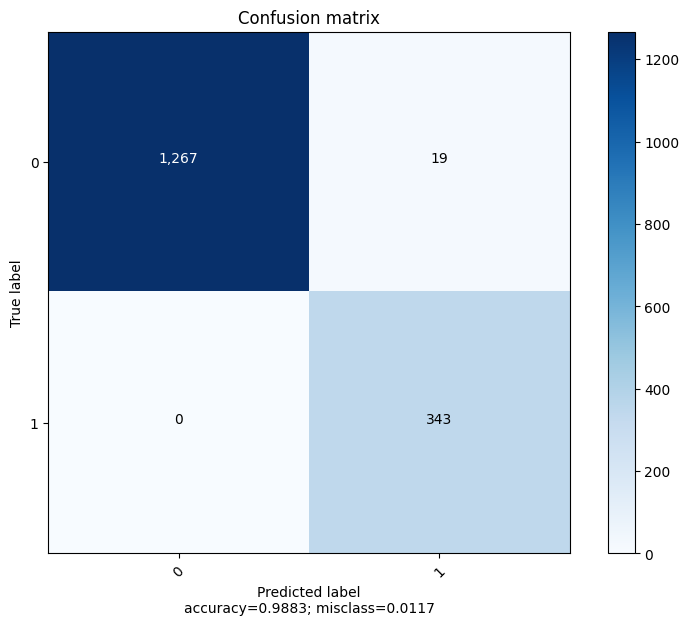

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 2
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 10

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.523 | Val Loss: 0.4547 | Train Acc: 78.3804| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.409 | Val Loss: 0.3364 | Train Acc: 78.6442| Val Acc: 81.0000
Epoch 003: | Train Loss: 0.287 | Val Loss: 0.2334 | Train Acc: 90.0675| Val Acc: 93.0000
Epoch 004: | Train Loss: 0.209 | Val Loss: 0.1817 | Train Acc: 93.6626| Val Acc: 94.0000
Epoch 005: | Train Loss: 0.170 | Val Loss: 0.1548 | Train Acc: 94.6380| Val Acc: 95.0000
Epoch 006: | Train Loss: 0.147 | Val Loss: 0.1380 | Train Acc: 95.5828| Val Acc: 95.0000
Epoch 007: | Train Loss: 0.131 | Val Loss: 0.1261 | Train Acc: 96.0859| Val Acc: 96.0000
Epoch 008: | Train Loss: 0.119 | Val Loss: 0.1166 | Train Acc: 96.3252| Val Acc: 96.0000
Epoch 009: | Train Loss: 0.110 | Val Loss: 0.1090 | Train Acc: 96.6380| Val Acc: 97.0000
Epoch 010: | Train Loss: 0.101 | Val Loss: 0.1025 | Train Acc: 96.9509| Val Acc: 97.0000
Epoch 011: | Train Loss: 0.095 | Val Loss: 0.0969 | Train Acc: 97.1902| Val Acc: 97.0000
Epoch 012: | Train Lo

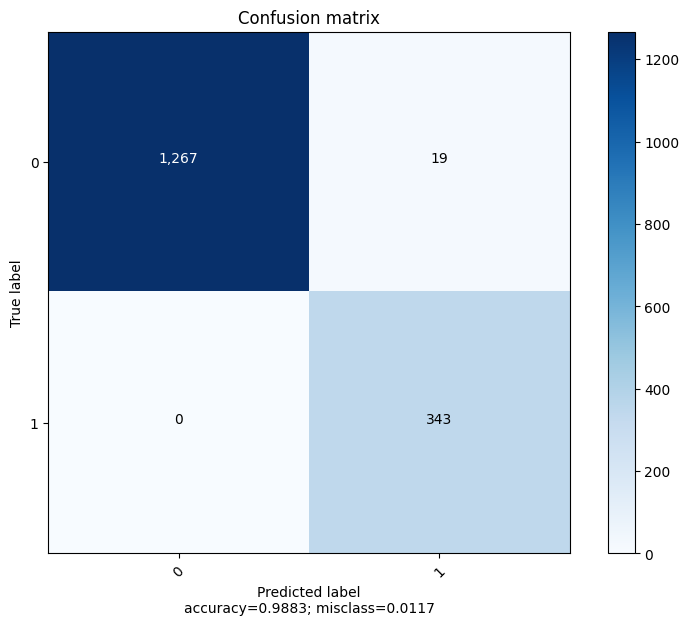

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 10
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 35



Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.517 | Val Loss: 0.4238 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.359 | Val Loss: 0.2812 | Train Acc: 82.0245| Val Acc: 88.0000
Epoch 003: | Train Loss: 0.243 | Val Loss: 0.2008 | Train Acc: 92.0184| Val Acc: 94.0000
Epoch 004: | Train Loss: 0.183 | Val Loss: 0.1631 | Train Acc: 94.9693| Val Acc: 95.0000
Epoch 005: | Train Loss: 0.153 | Val Loss: 0.1425 | Train Acc: 95.8650| Val Acc: 95.0000
Epoch 006: | Train Loss: 0.135 | Val Loss: 0.1288 | Train Acc: 96.1411| Val Acc: 96.0000
Epoch 007: | Train Loss: 0.121 | Val Loss: 0.1185 | Train Acc: 96.2699| Val Acc: 96.0000
Epoch 008: | Train Loss: 0.111 | Val Loss: 0.1103 | Train Acc: 96.5460| Val Acc: 96.0000
Epoch 009: | Train Loss: 0.102 | Val Loss: 0.1035 | Train Acc: 96.8405| Val Acc: 97.0000
Epoch 010: | Train Loss: 0.095 | Val Loss: 0.0977 | Train Acc: 97.1166| Val Acc: 97.0000
Epoch 011: | Train Loss: 0.089 | Val Loss: 0.0929 | Train Acc: 97.3374| Val Acc: 97.0000
Epoch 012: | Train Lo

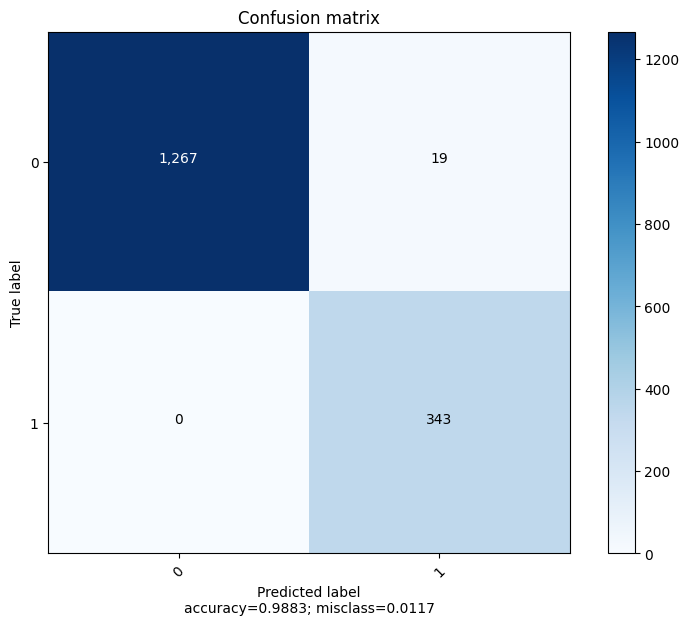

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 35
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 20

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.519 | Val Loss: 0.4421 | Train Acc: 78.4785| Val Acc: 80.0000
Epoch 002: | Train Loss: 0.396 | Val Loss: 0.3226 | Train Acc: 79.0368| Val Acc: 83.0000
Epoch 003: | Train Loss: 0.277 | Val Loss: 0.2233 | Train Acc: 88.2822| Val Acc: 93.0000
Epoch 004: | Train Loss: 0.200 | Val Loss: 0.1732 | Train Acc: 94.7117| Val Acc: 95.0000
Epoch 005: | Train Loss: 0.162 | Val Loss: 0.1478 | Train Acc: 95.6380| Val Acc: 95.0000
Epoch 006: | Train Loss: 0.140 | Val Loss: 0.1323 | Train Acc: 96.0123| Val Acc: 96.0000
Epoch 007: | Train Loss: 0.126 | Val Loss: 0.1212 | Train Acc: 96.1963| Val Acc: 96.0000
Epoch 008: | Train Loss: 0.114 | Val Loss: 0.1124 | Train Acc: 96.4540| Val Acc: 96.0000
Epoch 009: | Train Loss: 0.105 | Val Loss: 0.1053 | Train Acc: 96.7301| Val Acc: 97.0000
Epoch 010: | Train Loss: 0.098 | Val Loss: 0.0992 | Train Acc: 96.9877| Val Acc: 97.0000
Epoch 011: | Train Loss: 0.091 | Val Loss: 0.0940 | Train Acc: 97.1902| Val Acc: 97.0000
Epoch 012: | Train Lo

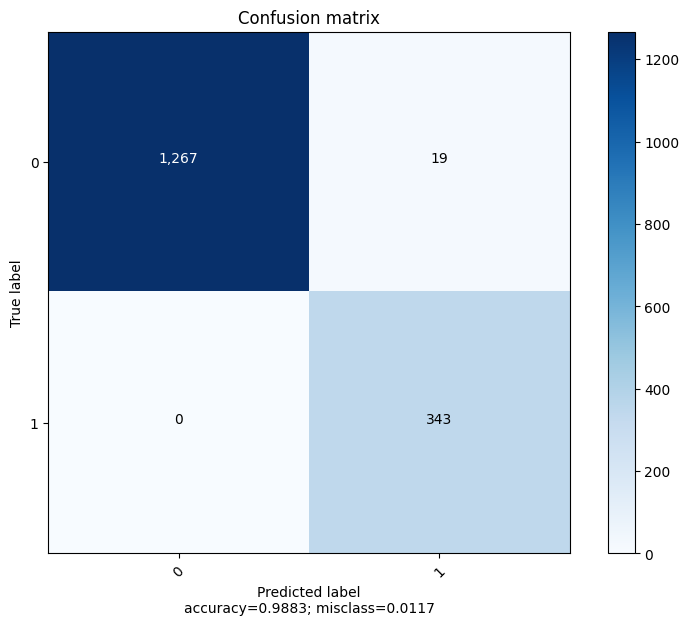

In [ ]:
lr = 0.05 #taxa de aprendizado
new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]
  #batch_size facilita no treinamento da rede por partes, importante nn ser mt pequeno pra nn ficar mt inconsistente 
batch_size = 32 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = 20, n_output=n_output,output_activation='sigmoid')
epochs = 250 #numero maximo de ciclos

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

##### hidden_neurons = 70

Binary classification


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.457 | Val Loss: 0.3536 | Train Acc: 78.0920| Val Acc: 82.0000
Epoch 002: | Train Loss: 0.300 | Val Loss: 0.2447 | Train Acc: 87.3742| Val Acc: 92.0000
Epoch 003: | Train Loss: 0.221 | Val Loss: 0.1934 | Train Acc: 93.8160| Val Acc: 94.0000
Epoch 004: | Train Loss: 0.181 | Val Loss: 0.1660 | Train Acc: 94.7423| Val Acc: 94.0000
Epoch 005: | Train Loss: 0.157 | Val Loss: 0.1480 | Train Acc: 95.3252| Val Acc: 95.0000
Epoch 006: | Train Loss: 0.141 | Val Loss: 0.1345 | Train Acc: 95.8589| Val Acc: 95.0000
Epoch 007: | Train Loss: 0.127 | Val Loss: 0.1235 | Train Acc: 96.1227| Val Acc: 96.0000
Epoch 008: | Train Loss: 0.116 | Val Loss: 0.1144 | Train Acc: 96.3436| Val Acc: 96.0000
Epoch 009: | Train Loss: 0.107 | Val Loss: 0.1067 | Train Acc: 96.7117| Val Acc: 97.0000
Epoch 010: | Train Loss: 0.099 | Val Loss: 0.1004 | Train Acc: 96.9877| Val Acc: 97.0000
Epoch 011: | Train Loss: 0.092 | Val Loss: 0.0951 | Train Acc: 97.1902| Val Acc: 97.0000
Epoch 012: | Train Lo

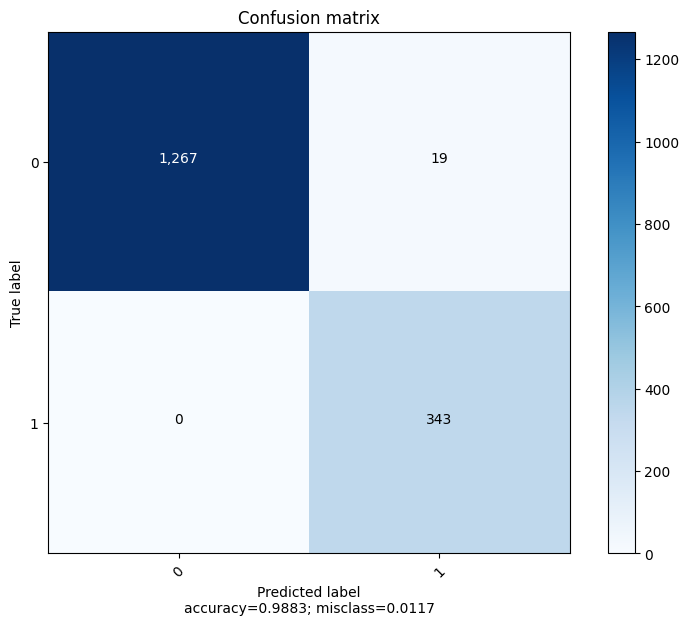

In [ ]:
lr = 0.05 #taxa de aprendizado
hidden_neurons = 70
epochs = 250 #numero maximo de ciclos
batch_size = 32 

new_df = transform_data(dataset, normalize=True)
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
model = NeuralNetwork(n_input = n_input,hidden_neurons = hidden_neurons, n_output=n_output,output_activation='sigmoid')


history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary,)
y_pred = model.predict(test_dataset.X_data, binary=binary)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

Testei com vários valores diferentes, e não obtive a resposta desejada. Os valores das métricas foram muito parecidos, apresentando uma pequena melhora com o aumento do número de neurônios. Por tal motivo, mantive os 20 neurônios no decorrer do trabalho. 

## Parte IV - Análise dos resultados - **Extra**

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: crie uma nova função (e.g. train_EarlyStopping) ou use um parâmetro para habilitar/desabilitar o Early Stopping.

#### Rascunho

#### Resposta

### 2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

> Indented block



Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

#### Rascunho

#### Resposta

### 3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

#### Resposta